In [1]:
import numpy as np
import copy
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau, LinearLR, ExponentialLR
import random
from torch.autograd.functional import jacobian#, hessian
# import AUTOGRAD.FUNCTIONAL.JACOBIAN as jacobian
import time
# import math
from IPython.display import display, Markdown

import matplotlib as mpl
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
mpl.rcParams['legend.fontsize'] = 10
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!python -V

Python 3.12.4


In [3]:
def Frobenius(A,B):
    return torch.vmap(torch.trace)(torch.bmm(A,torch.transpose(B,1,2)))

# Random sample generation

In [4]:
t0 = time.time()
num_samples = 2**16
num_time_intervals=20
dim = 10
size = num_samples* dim * num_time_intervals
iid = torch.randn(size=[size]).to(device)
print("It takes {:.0f} ms to generate {:,} iid samples.".format(round(1000*(time.time()-t0),6),size))


It takes 152 ms to generate 13,107,200 iid samples.


# Parameters of the PDEs

In [6]:
dim=2 # dim = n+1, n assets, 1 wealth + n stochastic volatilites. does not include time
# nonlinear PDE
pde_params={'dim':dim,
          'kappa':torch.tensor([0.,1.,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7]).to(device), # The first kappa=0 because the drift of wealth process is zero
          'theta':torch.tensor([0.,0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
          'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device),
          # 'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   Hung's params
          'lb':torch.tensor([0.,1.15,1.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device), # New params Make closed form solution more sensitive to time
          'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
          'eta':torch.tensor([1.]).to(device),
          'T': torch.tensor([1.]).to(device),
        }
# nonlinear PDE with OU processes
pde_params0={'dim':dim,
          'kappa':torch.tensor([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]).to(device), # The first kappa=0 because the drift of wealth process is zero
          'theta':torch.tensor([0.,0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
          'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device),
          'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   
          'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
          'eta':torch.tensor([1.]).to(device),
          'T': torch.tensor([1.]).to(device),
        }

# Parameters of simulation

In [8]:
sim_params={'num_samples':2**12,
          'num_time_intervals': 20,
          'iid':iid,
          'start' : torch.tensor([0.0]),  
          'end' : torch.tensor([1.0])        }

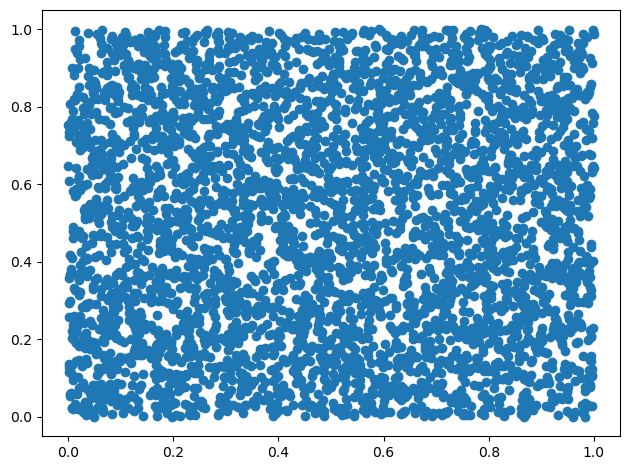

In [9]:
a = sim_params['start']
b = sim_params['end']
x0 = a+(b-a)*torch.rand(sim_params['num_samples'],dim).to(device)
plt.scatter(x0[:,0].numpy(),x0[:,dim-1].numpy());
plt.tight_layout(rect=[0,0,1,1]);

# Autograd for gradient and Hessian

## Gradient

In [10]:
def Grad(x,v): #output= [M,D,D], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    d = x.shape[1]
    hess_temp=torch.zeros(x.shape[0],d,d).to(device)
    Du=torch.zeros(x.shape[0],d).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    u=v(xin)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    Du = torch.reshape(Du,(Du.shape[0],d,1))
    return Du



## First and second derivative together

In [11]:
def Grad_Hess(x,v): #output= [M,D,D], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    d = x.shape[1]
    hess_temp=torch.zeros(x.shape[0],d,d).to(device)
    Du=torch.zeros(x.shape[0],d).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    u=v(xin)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    hess_temp= torch.cat([torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(d)],1)
    Du = torch.reshape(Du,(Du.shape[0],d,1))
    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],d,d))
    return Du, hess_temp



# Define NNs and coefficient functions

## Neural nets


### NNs for the solution and derivative

In [12]:
# Solution at t=0
class Ynet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(Ynet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim, 8),
            # nn.BatchNorm1d(num_features=8),# We should never use Batch mormalization in these type of problems when the input and scale back to a smaller region. The input is normalized with a different scale than the training data and out functions are going to be screwed.
            nn.Tanh(),
            nn.Linear(8, 8),
            # nn.BatchNorm1d(num_features=8),
            nn.Tanh(),
            nn.Linear(8,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits  
# derivative of the solution at all times
class Znet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(Znet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 8),
            nn.Tanh(),
            nn.Linear(8, 8),
            # nn.BatchNorm1d(num_features=20),
            nn.Tanh(),
            nn.Linear(8,dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])  
# Value of the solution at all times
class Ytnet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(Ytnet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 8),
            # nn.BatchNorm1d(num_features=8),
            nn.Tanh(),
            nn.Linear(8, 8),
            # nn.BatchNorm1d(num_features=8),
            nn.Tanh(),
            nn.Linear(8,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits    
           

### 1d NN for the diffusion coefficient of the wealth process

In [13]:
class sigma1D(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self,params):
        dim = params['dim']
        super(sigma1D, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            nn.BatchNorm1d(num_features=4),
            nn.Tanh(),
            nn.Linear(4,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])
    
class sigma(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self,dim):
        super(sigma, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            nn.BatchNorm1d(num_features=4),
            nn.Tanh(),
            nn.Linear(4,dim*dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])    


## Coefficients and boundary conditions

### Generic class that defines the coefficients and any boundary condition of the PDEs

In [14]:
'''Implements the coefficeints based on the parameters '''
class coefficient(object):
    def __init__(self,params): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
        self.dim=params['dim']#2
        self.nu = params['nu']
        self.kappa = params['kappa'][0:self.dim]
        self.theta = params['theta'][0:self.dim]
        self.eta = params['eta']
        self.lb = params['lb'][0:self.dim]
        self.lb_norm = torch.sqrt(torch.pow(params['lb'][0:self.dim],2).sum())
        self.params = params
    

### Diffuion coefficient

In [15]:
'''constant diffution coefficient'''  
class constant_diff(coefficient):
    '''This class is a constant diffusion coefficient which is the optimal diffusion'''
    def __init__(self,params,**kwargs):
        super(constant_diff, self).__init__(params)
        if kwargs:
            if 'constant_diff' in kwargs.keys():
                self.diff = kwargs['constant_diff']
            else:
                self.diff = torch.sqrt(torch.pow(self.lb,2).sum())/self.eta
        else:
            self.diff = torch.sqrt(torch.pow(self.lb,2).sum())/self.eta
    def __call__(self,x):
        tmp = x.shape[0]
        return torch.diag(torch.cat((self.diff,self.nu[0:self.dim-1]),axis=0)).repeat(tmp,1,1)

'''Random diffusion coefficient for wealth process with diffusion of volatility processes all constant'''   
class random_diff(coefficient):
    def __init__(self,params):
        super(random_diff, self).__init__(params)
    def __call__(self,x):
        tmp = x.shape[0]
        return torch.diag(torch.cat((torch.rand(tmp,1),self.nu[0:self.dim-1].repeat(tmp,1)),axis=0))
    
'''NN diffusion coefficient for wealth process  with diffusion of volatility processes all constant'''
class NN_diff_1D(coefficient):
    def __init__(self,params,**kwargs):
        super(NN_diff_1D, self).__init__(params)
        if kwargs:
            if 'diff' in kwargs.keys():
                if torch.is_tensor(kwargs['diff']):
                    self.s = lambda x:kwargs['diff']
                else:
                    self.s = kwargs['diff']
            else:
                self.s = sigma1D(params)
                print("Warning: since the coefficient in not created using diff = diffusion(params), the diffusion coefficient is set to a neural net in first variable.")
            if 'update' in kwargs.keys():
                self.update = kwargs['update']
            else:
                self.update = lambda x: torch.zeros(x.shape[0],1)
                print("Warning: since the coefficient in not created using update = function, the update function is set to zero.")
        else:
            self.s = sigma1D(params)#Define an update function only for this coefficient to change its value.
            self.update = lambda x: torch.zeros(x.shape[0],1) 
    def __call__(self,x):
        tmp = self.s(x) + self.update(x)
        shp = x.shape[0]
        return torch.diag_embed(torch.cat((tmp,self.nu[0:self.dim-1].repeat(shp,1)),axis=1))

# class updated(coefficient):
#     def __init__(self,params,coef,adjust):
#         self.adjust = adjust
#         self.coef = coef
#         super(update, self).__init__(params)
#     def __call__(self,x):
#         return self.coef(x) + self.adjust(x)    
    
'''NN diffusion for all components'''    
class NN_diff(coefficient):
    def __init__(self,params):
        super(NN_diff, self).__init__(params)
        self.s = sigma(self.dim)
    def __call__(self,x):
        return self.s0(x)
    

''' diffusion'''
class custom_diff(coefficient):
    def __init__(self, params,s):
        super(custom_diff, self).__init__(params)
        if torch.is_tensor(s):
            self.s = lambda x:s
        else:
            self.s = s
    def __call__(self, x):
        dim = pde_params['dim']
        num_samples = x.shape[0]
        A=torch.zeros(num_samples,dim,dim)
        A[:,1:,1:] = torch.diag(pde_params['nu'][0:dim-1])
        A[:,0,0] = self.s(x)
        return A



In [16]:
# s = sigma1D(pde_params)
# u = sigma1D(pde_params)


In [17]:
# t = NN_diff_1D(pde_params,diff = s, update = u)

In [18]:
    # t(input).shape

In [19]:
# t = constant_diff(pde_params)
# t(input)

### Zero drift 

In [20]:
'''Zero drift coefficient for all components'''  
class zero_drift(coefficient):
    def __init__(self,params):
        super(zero_drift, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],x.shape[1]-1)

### Drift for the semilinear

In [21]:
'''Drift of semilinear eqn: first component drift=0, others are OU'''
class OU_drift_semi(coefficient):
    def __init__(self,params):
        super(OU_drift_semi, self).__init__(params)
    def __call__(self,x):
        num_samples = x.shape[0]
        output = torch.zeros(num_samples,dim)
        for i in range(0,self.dim):
            output[:,i] = self.kappa[i]*(self.theta[i] - x[:,i])
        return output
 
 

### Drift for linear equation

In [22]:
'''Drift of linear eqn: first component drift =|lb|*sgn(v_e)sigma_{00}(x), others are OU'''
class OU_drift_lin(coefficient):
    def __init__(self,params,v,sigma):
        self.p = v
        self.sigma = sigma
        super(OU_drift_lin, self).__init__(params)
    def __call__(self,x):
        num_samples = x.shape[0]
        q = self.p(x)[:,0]
        output = torch.zeros(num_samples,dim)
        output[:,0] = torch.sqrt(torch.pow(self.lb,2).sum())*torch.sgn(q)*self.sigma(x)[:,0,0]
        for i in range(1,self.dim):
            output[:,i] = self.kappa[i]*(self.theta[i] - x[:,i])
        return output 
    
    
class custom_drift(coefficient):
    def __init__(self, params,s,sigma):
        super(custom_drift, self).__init__(params)
        if torch.is_tensor(s):
            self.s = lambda x:s
        else:
            self.s = s
            if torch.is_tensor(sigma):
                self.sigma = lambda x:sigma
            else:
                self.sigma = sigma
            self.lb_norm = torch.sqrt(torch.pow(params['lb'][0:params['dim']],2).sum())
    def __call__(self, x):
        num_samples = x.shape[0]
        output = torch.zeros(num_samples,dim)
        for i in range(1,self.dim):
            output[:,i] = self.kappa[i]*(self.theta[i] - x[:,i])
        output[:,0] = self.lb_norm*torch.sgn(Grad(x,self.s)[:,1].squeeze(-1))
        return output    

In [23]:
# s = sigma1D(pde_params)
# sigma = NN_diff_1D(pde_params,diff = s)
# v = sample_Znet()
# v(input)[:,0]

In [24]:
# s(input).shape

In [25]:
# lin_drift_1 = OU_drift_lin(pde_params,v,sigma)

In [26]:
# lin_drift_1(input).shape

### Driver of the semilinear BSDE

In [27]:
class f_driver(coefficient):
    def __init__(self,params): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
        super(f_driver, self).__init__(params)
    def __call__(self,z,a):
        return -torch.sqrt(torch.sum(torch.square(self.lb)))*torch.abs(z[:,0,0])*torch.abs(a)# + output


### Source

In [28]:
class zero_source(coefficient):
    def __init__(self,params):
        super(zero_source, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],1)   
    
class custom_source(coefficient):
    def __init__(self,params,source):
        if torch.is_tensor(source):
            self.val = lambda x:source 
        else:
            self.val = source
        super(custom_source, self).__init__(params)
    def __call__(self,x):
        return self.val(x) 
    
class direction(coefficient):
    def __init__(self,params,v,sigma,magnitude):
        self.p = v# we need to evaluate gradient and hessian of v
        self.sigma = sigma
        if torch.is_tensor(magnitude):
            self.magnitude = lambda x:magnitude.repeat(x.shape[0],1)
        else:
            self.magnitude = magnitude
        super(direction, self).__init__(params)
    def __call__(self,x):
        D2 = Grad_Hess(x,self.p)[1][:,1:,1:]
        D1 = Grad_Hess(x,self.p)[0][:,1]
        A = torch.zeros(x.shape[0],dim,dim)
        A[:,0,0] = -self.lb_norm*torch.abs(D1.squeeze(-1))#
        A = A-torch.bmm(self.sigma(x),D2)
        # print(self.magnitude(x).shape)
        return torch.bmm(torch.diag_embed(self.magnitude(x).repeat(1,self.params['dim'])),A)            
    
class source_from_direction(coefficient): # source term for the linear equations
    def __init__(self,params,direction):
        self.p = v# we need to evaluate gradient and hessian of v
        self.sigma = sigma
        # self.alpha = direction.magnitude
        self.direction = direction
        super(source_from_direction, self).__init__(params)
    def __call__(self,x):
        A = self.direction(x)
        return torch.sqrt(Frobenius(A,A)).unsqueeze(-1)
        

### Zero discount 

In [29]:
'''Zero drift coefficient for all components'''  
class zero_discount(coefficient):
    def __init__(self,params):
        super(zero_discount, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],1)

## New coefficient from others

In [30]:
class add_coeff(coefficient):
    def __init__(self,s1,s2):
        self.s1 = s1
        self.s2 = s2
        super(add_coeff, self).__init__(s1.params)
    def __call__(self,x):
        return self.s1(x)+self.s2(x)
        

## Terminal condition

In [31]:
class exponential_terminal(coefficient):
    def __init__(self,params):
        self.eta = params['eta']
    def __call__(self,x):
        return (torch.tensor([1.])-torch.exp(-self.eta*x[:,0])).unsqueeze(-1)

In [32]:
class zero_terminal(coefficient):
    def __init__(self,params):
        self.eta = params['eta']
    def __call__(self,x):
        num_samples = x.shape[0]
        return torch.zeros(num_samples,1)

In [33]:
input = x_tmp

In [34]:
g = exponential_terminal(pde_params)
g(x_tmp[:,1:])

tensor([[0.5093],
        [0.6279],
        [0.3126],
        [0.5549],
        [0.0076],
        [0.3688],
        [0.0928],
        [0.2533],
        [0.3398],
        [0.4213]])

## Closed-form solution

$v(w,y_1,...,y_d,t)=1-\exp\left(-\eta w - \frac12{|\lambda|^2}(T-t)\right)$

In [35]:
class solution(object):
    def __init__(self,params):
        self.dim=params['dim']#2
        self.nu = params['nu']
        self.kappa = params['kappa'][0:self.dim]
        self.theta = params['theta'][0:self.dim]
        self.eta = params['eta']
        self.lb = params['lb'][0:self.dim]
        self.T = params['T']
        
        
class exp_solution(solution):
    def __init__(self,params,alpha):
        self.alpha = alpha
        super(exp_solution, self).__init__(params)
    def __call__(self,x):
        # print(self.alpha)
        return torch.tensor([1.])-torch.exp(-self.eta*x[:,1]+self.alpha*(self.T-x[:,0])).to(device)     

class zero_solution(solution):
    def __init__(self,params):
        super(zero_solution, self).__init__(params)
    def __call__(self,x):
        # print(self.alpha)
        return torch.zeros([x.shape[0],1]).to(device) 
    
class time_solution(solution):
    def __init__(self,params,constant):
        self.constant = constant
        super(time_solution, self).__init__(params)
    def __call__(self,x):
        return (self.T-x[:,0].unsqueeze(-1))*self.constant*torch.ones([x.shape[0],1]).to(device)    

In [36]:
alpha = pde_params['eta']*pde_params['eta']*(0.5*pde_params['eta']*pde_params['eta']-torch.sqrt(torch.pow(pde_params['lb'][0:pde_params['dim']],2).sum()))
sol_semi = exp_solution(pde_params,alpha)
alpha = 0.5*torch.pow(pde_params0['eta']*pde_params0['eta'],2)
sol_lin = exp_solution(pde_params0, alpha)
zero_lin = zero_solution(pde_params0)
sol_semi(torch.Tensor([[1.,0.,10.],[0.,0.,1.]])),sol_lin(torch.Tensor([[1.,0.,10.],[0.,0.,1.]]))

(tensor([0.0000, 0.4780]), tensor([ 0.0000, -0.6487]))

#### Plot closed form solution

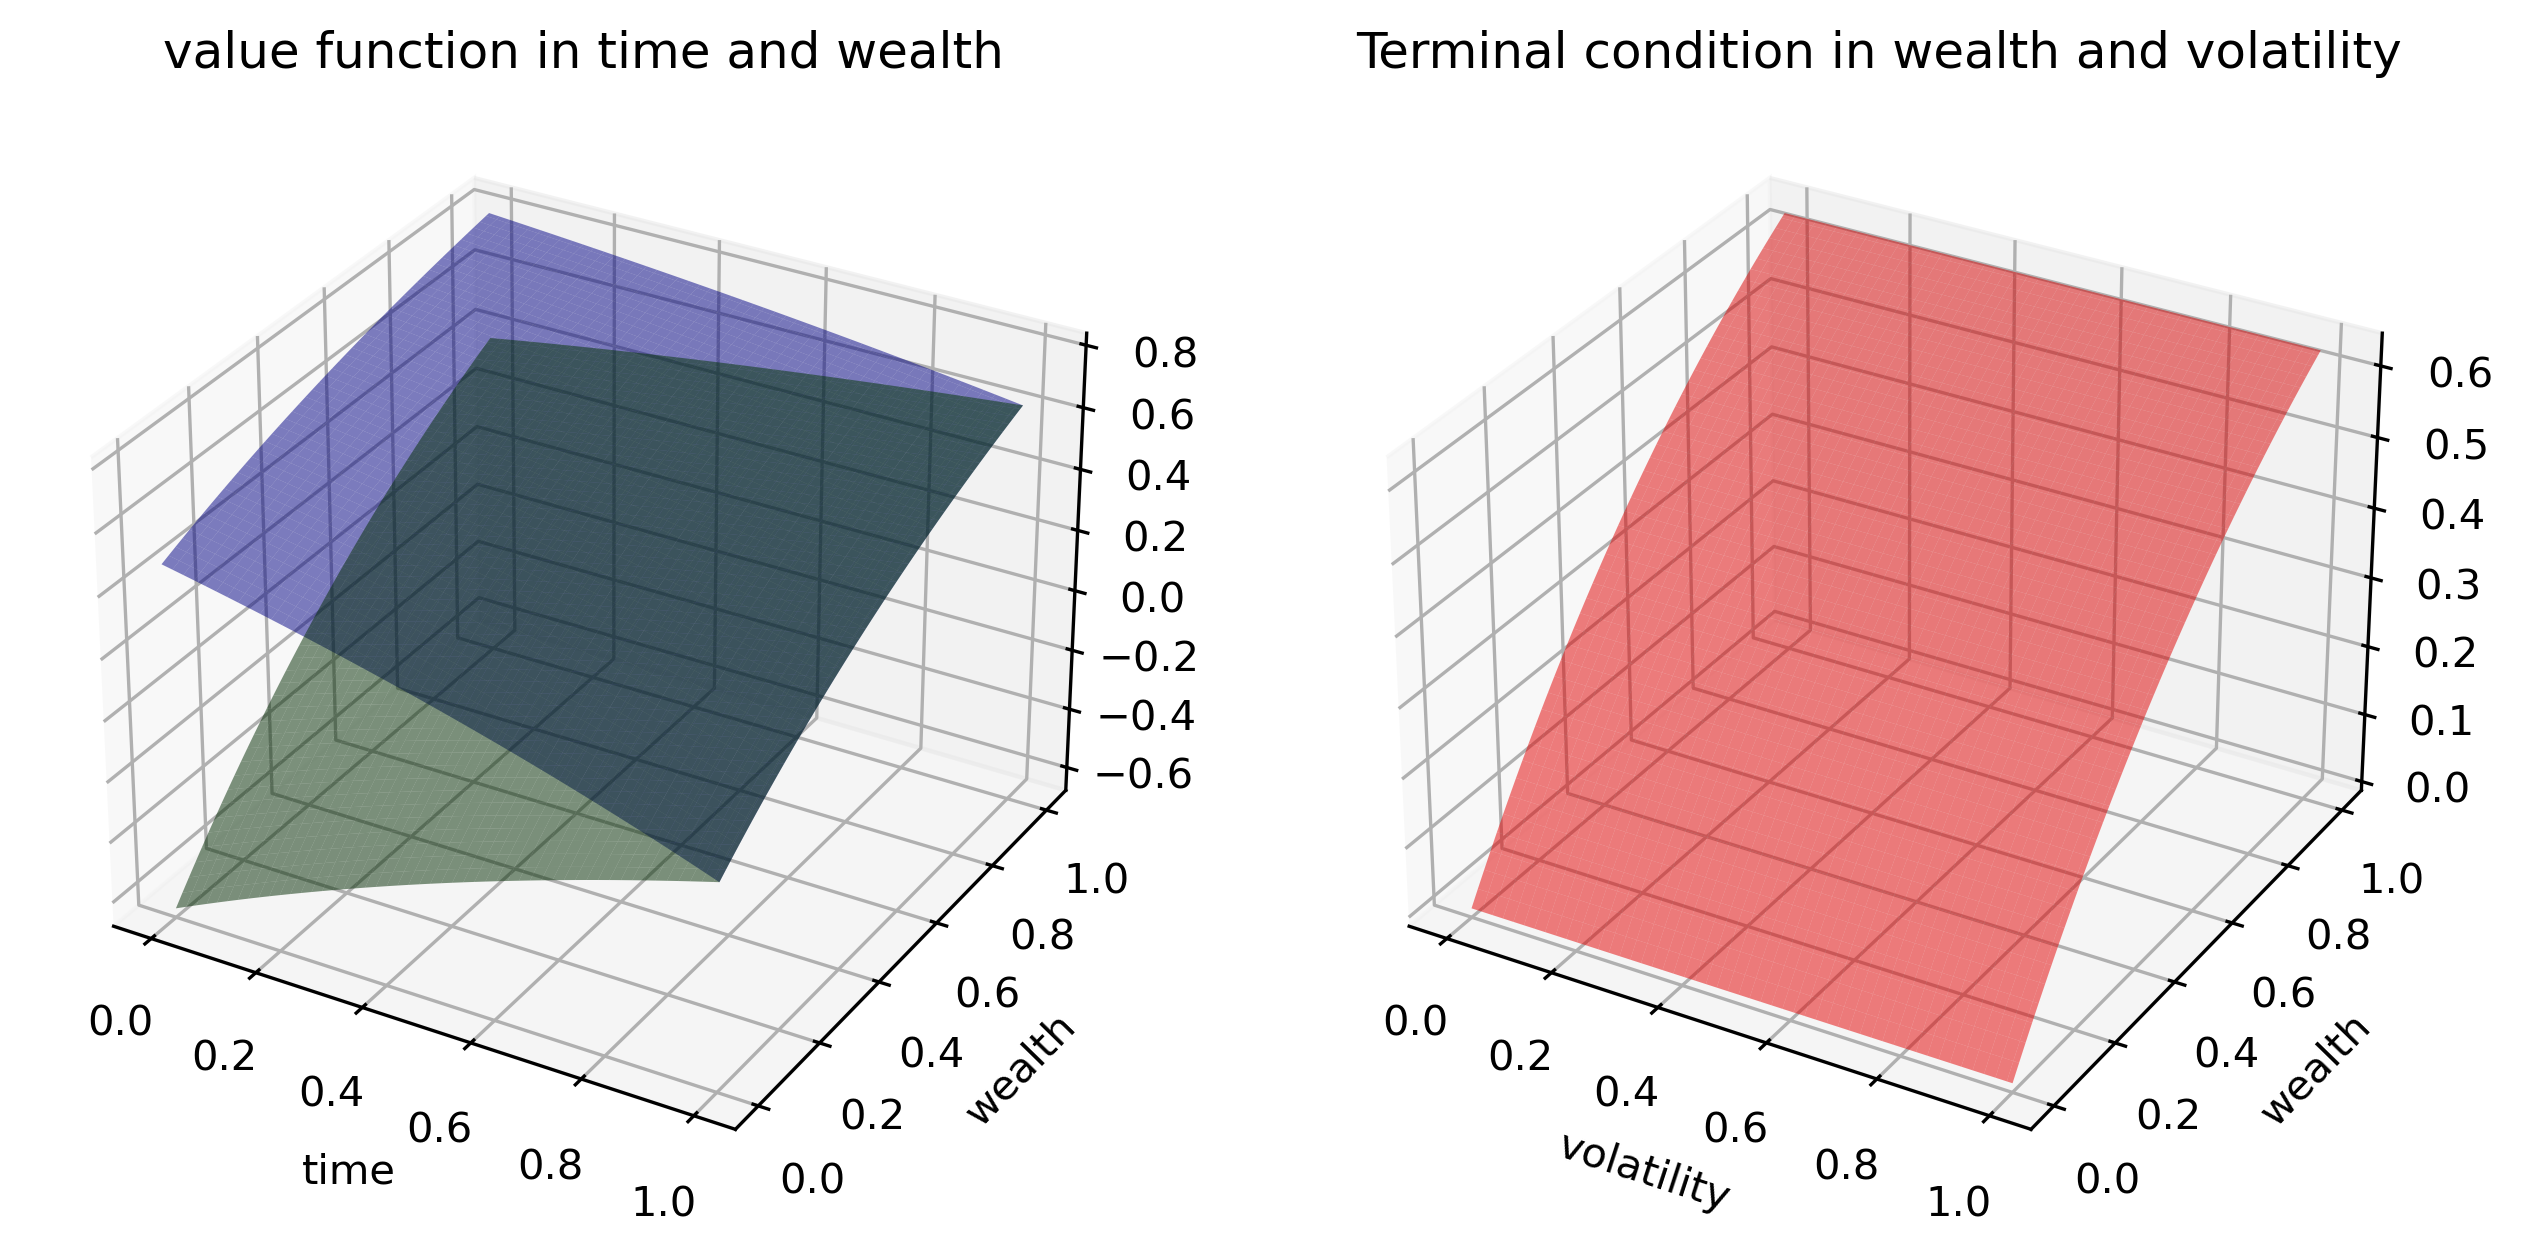

In [37]:
steps =100
x = torch.linspace(0.0,1.,steps=steps)
y = torch.linspace(0.0,1.,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
v_T = g(xy).detach().reshape(steps,steps).squeeze(-1)
v_l = sol_semi(xy).detach().reshape(steps,steps).squeeze(-1)
v_s = sol_lin(xy).detach().reshape(steps,steps).squeeze(-1)
f = plt.figure(figsize=(10,3),dpi=300);
ax0 = f.add_subplot(1, 2, 1, projection='3d')
ax0.plot_surface(x.numpy(),y.numpy(),v_l.numpy(),color='b',alpha=0.5);
ax0.plot_surface(x.numpy(),y.numpy(),v_s.numpy(),color='g',alpha=0.5);
ax0.set_xlabel('time')
ax0.set_ylabel('wealth')
ax0.set_title("value function in time and wealth")

ax1 = f.add_subplot(1, 2, 2, projection='3d')
ax1.plot_surface(y.numpy(),x.numpy(),v_T.numpy(),color='r',alpha=0.5);
ax1.set_ylabel('wealth')
ax1.set_xlabel('volatility');
ax1.set_title("Terminal condition in wealth and volatility")
plt.tight_layout(rect=(-0., -0.2, 1, 1.2));


# Sample generation based using defined coefficients

In [38]:
class data_gen(object):
    def __init__(self,sigma,mu,pde,sim):
        self.mu = mu
        self.sigma = sigma
        a = sim['start']
        b = sim['end']
        iid = sim['iid']
        num_samples = sim['num_samples']
        n = sim['num_time_intervals']
        dim = pde['dim']
        self.dt = torch.tensor([pde['T']/sim['num_time_intervals']]).to(device)
        dw = iid[0:num_samples*dim*n].reshape([num_samples,dim,n]).to(device)* torch.sqrt(self.dt)#you can make randomness a universal variable if 
        self.x = torch.zeros((num_samples,dim+1,n+1))
        
        self.x[:,1:,0]= a+(b-a)*torch.rand(num_samples,dim).to(device)  
        self.sigmadw = torch.zeros((num_samples,dim,n)).to(device)
        for i in range(n):
            self.sigmadw[:,:,i] = torch.bmm(self.sigma(self.x[:,:,i]).reshape((num_samples,dim,dim)),dw[:, :, i].unsqueeze(2)).squeeze(2)
            self.x[:,1:,i+1] = self.x[:,1:,i] + self.mu(self.x[:,:,i])*self.dt + self.sigmadw[:,:,i]
            self.x[:,0,i+1] = self.x[:,0,i]+self.dt

In [39]:
# v = sample_Znet()
# s = sigma1D(pde_params)
# sigma = NN_diff_1D(pde_params,diff = s)
# mu =OU_drift_lin (pde_params,v,sigma)
# a = torch.tensor([0.0])
# b = torch.tensor([1.0])
# T = pde_params['T']
# n = 20
# num_samples = 2**14

In [40]:
# sigma(input).shape

In [41]:
# data = data_gen(sigma,mu,pde_params,sim_params)
# data.x.shape

## Plot functions

In [42]:
def display_it(eqn,**kwargs):
    if dim == 2:
        f,ax = plt.subplots(1,1,figsize=(6,6),dpi=300);
        ax = plt.axes(projection='3d')
        ax.set_xlabel('wealth')
        ax.set_ylabel('volatility');
        
        fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o',alpha=0.5)#fitted
        fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='gray', marker = 'o',alpha=0.5)#terminal

        fake_leg = [fake2Dline1, fake2Dline2]
        leg_labels = ["Fitted","Terminal"]
        
        steps =100
        x = torch.linspace(0.,1.,steps=steps)
        y = torch.linspace(0.,1.,steps=steps)
        xy = torch.cartesian_prod(x,y)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        v_T = eqn.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
        surf = ax.plot_surface(X.numpy(),Y.numpy(),v_T.numpy(),alpha=0.5,label='Terminal',color='gray');

        if kwargs:
            if 't' in kwargs.keys():
                t = kwargs['t']
                txy = torch.cat((t*torch.ones(xy.shape[0],1),xy),axis=1)
            else:
                txy = torch.cat((torch.zeros(xy.shape[0],1),xy),axis=1)
                v = eqn.Y0(xy).detach().reshape(steps,steps).squeeze(-1)
                surf = ax.plot_surface(X.numpy(),Y.numpy(),v.numpy(),alpha=0.5,label="approximation",color='b');
                fake2Dline3 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o',alpha=0.5)#approximation
                fake_leg.append(fake2Dline3)
                leg_labels.append("Approximation at 0")
                

        
        vt = eqn.Yt(txy).detach().reshape(steps,steps).squeeze(-1)
        surf = ax.plot_surface(X.numpy(),Y.numpy(),vt.numpy(),alpha=0.5,label="fitted",color='r');
        
        if kwargs:
            if 'closed_form' in kwargs.keys():
                sol = kwargs['closed_form']
                v_c = sol(txy).detach().reshape(steps,steps).squeeze(-1)                
                surf = ax.plot_surface(X.numpy(),Y.numpy(),v_c.numpy(),alpha=0.5,label='closed-form',color='g');
                leg_labels.append("Closer-from")
                fake2Dline4 = mpl.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o',alpha=0.5)                
                fake_leg.append(fake2Dline4)
        
        
        if kwargs:
            if 'zlim' in kwargs.keys():
                ax.set_zlim(kwargs['zlim'])
            if 'legend_loc' in kwargs.keys():
                legend_loc = kwargs['legend_loc']
            else:
                legend_loc=(0.0,0.7)

        
        ax.legend(fake_leg, leg_labels, numpoints = 1, loc=legend_loc)
        plt.tight_layout(rect=[0,0,1,1]);      
    if kwargs:
        if 'closed_form' in kwargs.keys():
            sol = kwargs['closed_form']
            v_0 = sol(txy).detach().reshape(steps,steps).squeeze(-1)
            data = torch.rand(2**14,dim)
            tdata = torch.cat((torch.zeros(data.shape[0],1),data),axis=1)
            v_ = eqn.Yt(tdata).detach().squeeze(-1)
            v = eqn.Y0(data).detach().squeeze(-1)
            v_0 = sol(tdata).detach().squeeze(-1)
            display(Markdown("The $L^2$ distance between the fitted value function and closed-form for optimal $\sigma$ is  {:.3E}.".format(pow(v_-v_0,2).mean())))  
            display(Markdown("The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  {:.3E}.".format(pow(v-v_0,2).mean())))  


<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_47084/3415162522.py:69: SyntaxWarning: invalid escape sequence '\s'
  display(Markdown("The $L^2$ distance between the fitted value function and closed-form for optimal $\sigma$ is  {:.3E}.".format(pow(v_-v_0,2).mean())))
/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_47084/3415162522.py:70: SyntaxWarning: invalid escape sequence '\s'
  display(Markdown("The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  {:.3E}.".format(pow(v-v_0,2).mean())))


# Solving linear equations

$\begin{cases}-\partial v_t - \dfrac12 (\sigma^\intercal\sigma): D^2v -\mu\cdot\nabla v + f(t,x) =0\\
v(T,x)=g(x)
\end{cases}$

$\sigma(t,x)$ has shape [num_samples,dim,dim]
$dW_t$  has shape [num_samples,dim]

We need to unsqueeze $dW_t$ before batch multiplication.

    
    torch.bmm(sigma(x[:,:,i]),dw[:, :, i]dw[:, :, i].unsqueeze(2))



## Linear without Z

In [43]:
class linear(object):
    def __init__(self,sigma,mu,source,kappa,terminal,pde,sim):        
        self.Y0 = Ynet() # NN for value at t=0 
        # self.Z = Znet() # NN for gradient at all times
        self.Yt = Ytnet() # NN for value function at all times, required to update sigma
        self.terminal = terminal # terminal condition
        self.loss_epoch = [] # list to keep the loss at each training epoch
        self.epoch=0 # initializing epoch to zero
        # self.num_epochs = 5000 # total number of epochs
        self.mu = mu # drift of the SDE
        self.sigma = sigma # diffusion coef. for SDE
        self.kappa = kappa # discount factor
        self.source = source # source term for the PDE
        self.n = sim['num_time_intervals'] # number of time intervals
        # self.num_samples = sim['num_samples'] # number of samples 
        self.dim = pde['dim']
        data = data_gen(sigma,mu,pde,sim)
        self.dt = data.dt.to(device)
        self.x = data.x.to(device).clone().detach()
        self.sigmadw = data.sigmadw.to(device).clone().detach()
        self.r = torch.ones((self.x.shape[0],1,self.n+1)).to(device)
        self.c = torch.ones((self.x.shape[0],1,self.n+1)).to(device)
        for i in range(self.n):
            self.r[:,:,i+1] = self.r[:,:,i]* torch.exp(-self.kappa(self.x[:,:,i])*self.dt)
            if i == self.n -1 :
                self.c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
            self.c[:,:,i] = self.source(self.x[:,:,i])
        self.r = self.r.clone().detach()
        self.c = self.c.clone().detach()
        self.trained = False
        
    def loss(self):
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                Z = Grad(self.x[:,:,i],self.Yt)[:,1:,:].view(-1,1,self.dim)
                # print(Z.shape,self.sigmadw[:,:,i].unsqueeze(2).shape)
                Y = Y*self.r[:,:,i] + self.c[:,:,i]*self.dt + torch.bmm(Z,self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
            L1 = torch.pow(self.c[:,:,-1]-Y,2)
            L2 = torch.pow(self.Y0(self.x[:,1:,0])-self.Yt(self.x[:,:,0]),2)# Match with Y0
            L3 = torch.pow(self.c[:,:,-1]-self.Yt(self.x[:,:,-1]),2) # match with terminal
            L = L1 + L2 + L3
        return L.mean()
        
    def train(self,lr,delta_loss,max_num_epochs):
        t_0 = time.time()
        self.lr = lr
        parameters = list(self.Y0.parameters()) + list(self.Yt.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = torch.Tensor([-2.0])
        loss = torch.Tensor([2.0])
        while (torch.abs(L_-loss)>delta_loss) & (self.epoch < max_num_epochs):# epoch in range(num_epochs):
            t_1 = time.time()
            optimizer.zero_grad()
            if self.epoch>0:
                L_ = self.loss_epoch[self.epoch-1]
            loss= self.loss()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
            loss.backward()
            optimizer.step()
            self.loss_epoch.append(loss)
            if (self.epoch % int(max_num_epochs/10)== int(max_num_epochs/10)-1) | (self.epoch == 0):
                print("At epoch {}, mean loss is {:.2E}.".format(self.epoch+1,loss.detach()))
                self.time_display(t_0, t_1)
            self.epoch += 1
        print("Training took {} epochs and {:,} ms and the final loss is {:.2E}.".format(self.epoch,round(1000*(time.time()-t_0),2),loss))
        self.trained = True
        # self.value_fnc(lr=1e-2,delta_loss=delta_loss,max_num_epochs=1000,num_batches=10)

    def time_display(self, t_0, t_1):
        print("Training this epoch takes {:,} ms. So far: {:,} ms in training.".format(round(1000*(time.time()-t_1),2),round(1000*(time.time()-t_0),2)))
        
        
    # def value_fnc(self,lr,delta_loss,max_num_epochs,num_batches):
    #     t_0 = time.time()
    #     if self.trained == False:
    #         print("The neural nets are not trained yet. Train the neural nets by running self.train(lr,delta_loss,max_num_epochs).")
    #     else:
    #         for i in range(self.n):   
    #             if i == 0:
    #                 Y =  self.Y0(self.x[:,1:,0])
    #                 x_data = self.x[:,:,i]
    #                 y_data = Y
    #             else:
    #                 if i == self.n - 1:
    #                     Y = self.terminal(self.x[:,1:,i+1])
    #                     x_data = torch.cat((x_data,self.x[:,:,i+1]),axis=0)
    #                     y_data = torch.cat((y_data,Y),axis=0)
    #                     #evaluate and reuse self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))[:,0,0] 
    #                 Y = Y*self.r[:,:,i] + self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)        
    #                 x_data = torch.cat((x_data,self.x[:,:,i]),axis=0)
    #                 y_data = torch.cat((y_data,Y),axis=0)
    #         print("Data for value function is gathered in {:,} ms.".format(round(1000*(time.time()-t_0),2)))
    #         perm = torch.randperm(x_data.shape[0])
    #         y_data = y_data[perm,:].clone().detach()
    #         x_data = x_data[perm,:].clone().detach()
    #         parameters = self.Yt.parameters()
    #         optimizer = optim.Adam(parameters, lr)
    #         L_ = torch.Tensor([-2.0])
    #         loss = torch.Tensor([2.0])
    #         initiation = True # to print the first epoch or last epoch in multiple rounds of training
    #         epoch=0
    #         mse = nn.MSELoss()
    #         batch_size = int(x_data.shape[0]/num_batches)
    #         batch_epochs = int(max_num_epochs/num_batches)
    #         b=0
    #         # loss_epoch = []
    #         # max_num_epochs = 500
    #         t_0 = time.time()
    #         while (torch.abs(L_-loss)>delta_loss) & (epoch < max_num_epochs):# epoch in range(num_epochs):
    #             optimizer.zero_grad()
    #             if epoch>0:
    #                 L_ = loss
    #             index = [b*batch_size, x_data.shape[0]] if (b+1==num_batches) else [b*batch_size, (b+1)*batch_size]    
    #             loss= mse(self.Yt(x_data[index[0]:index[1],:]),y_data[index[0]:index[1],:])
    #             loss.backward()
    #             optimizer.step()
    #             if epoch == (b+1)*batch_epochs:
    #                 print("At epoch {:,} batch {} is used.".format(epoch+1,b+2))
    #             if epoch >= (b+1)*batch_epochs:
    #                 b = b + 1
                
    #             if initiation:
    #                 initiation = False
    #                 print("\nFitting a neural net to the data initiated.")
    #                 print("The L^2 error of the fitted value function at epoch {} is {:.2E}.".format(epoch+1,torch.sqrt(loss.detach())))
    #             if (epoch % int(max_num_epochs/5)== int(max_num_epochs/5)-1):    
    #                 print("The $L^2$-norm of the error of the fitted value function at epoch {} is {:.2E}.".format(epoch+1,torch.sqrt(loss.detach())))
    #             epoch += 1
    #         print("Value function is evaluated in {:,} ms.".format(round(1000*(time.time()-t_0),2)))


$\mu=$ OU with first component zero, $\sigma=1$, $\kappa=0$, $f=0$, and terminal $1-\exp(-\eta w)$

$\begin{cases}-v_t-\frac12\sigma^2v_{ww}-\mathcal{L}^Yv+f=0\\ v(e,y,T)=1-\exp(-\eta w)\end{cases}$

Closed-from is $v(w,y,t)=1-\exp\big(-\eta w+\alpha (T-t)\big)$ with $\alpha=\frac12\sigma^2\eta^2$



In [44]:
# v = sample_Znet()
# s = sigma1D(pde_params)
# sigma = NN_diff_1D(pde_params,diff = s) 
mu = OU_drift_semi(pde_params)
off_diff = torch.tensor([1.0]) #choose larger diffusion coef to make the difference between the terminal and time-zero solution larger
sigma = constant_diff(pde_params,constant_diff = off_diff)# With large constant_diff the trainning sucks!
# mu = OU_drift_lin(pde_params,v,sigma)

k = zero_discount(pde_params)
f = zero_source(pde_params)
# f = custom_source(pde_params,off_diff)
g = exponential_terminal(pde_params)
# g = zero_terminal(pde_params)

In [45]:
heat = linear(sigma,mu,f,k,g,pde_params,sim_params)

In [46]:
heat.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1, mean loss is 5.34E+00.
Training this epoch takes 704.0 ms. So far: 1,232.87 ms in training.
At epoch 500, mean loss is 1.21E-01.
Training this epoch takes 340.41 ms. So far: 256,678.72 ms in training.
At epoch 1000, mean loss is 1.02E-01.
Training this epoch takes 408.03 ms. So far: 511,442.35 ms in training.
At epoch 1500, mean loss is 9.64E-02.
Training this epoch takes 683.01 ms. So far: 860,645.47 ms in training.
At epoch 2000, mean loss is 9.45E-02.
Training this epoch takes 454.0 ms. So far: 1,122,549.02 ms in training.
At epoch 2500, mean loss is 9.32E-02.
Training this epoch takes 818.84 ms. So far: 1,520,986.19 ms in training.
At epoch 3000, mean loss is 9.19E-02.
Training this epoch takes 926.38 ms. So far: 4,714,485.45 ms in training.
At epoch 3500, mean loss is 9.04E-02.
Training this epoch takes 553.73 ms. So far: 6,002,169.47 ms in training.
At epoch 4000, mean loss is 8.94E-02.
Training this epoch takes 832.85 ms. So far: 7,248,601.09 ms in training.
At epoch

In [47]:
# heat.value_fnc(lr=1e-2,delta_loss=1e-9,max_num_epochs=1000,num_batches=10)
# print(heat.x_data.shape,heat.y_data.shape)

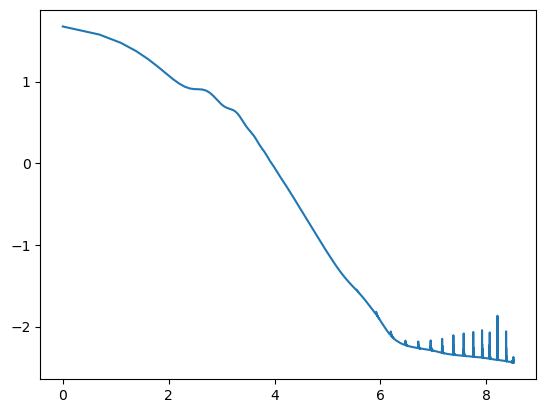

In [48]:
plt.plot(np.log(np.arange(len(heat.loss_epoch))+1),[np.log(l.detach().numpy()) for l in heat.loss_epoch]);

The $L^2$ distance between the fitted value function and closed-form for optimal $\sigma$ is  3.072E-04.

The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  2.873E-04.

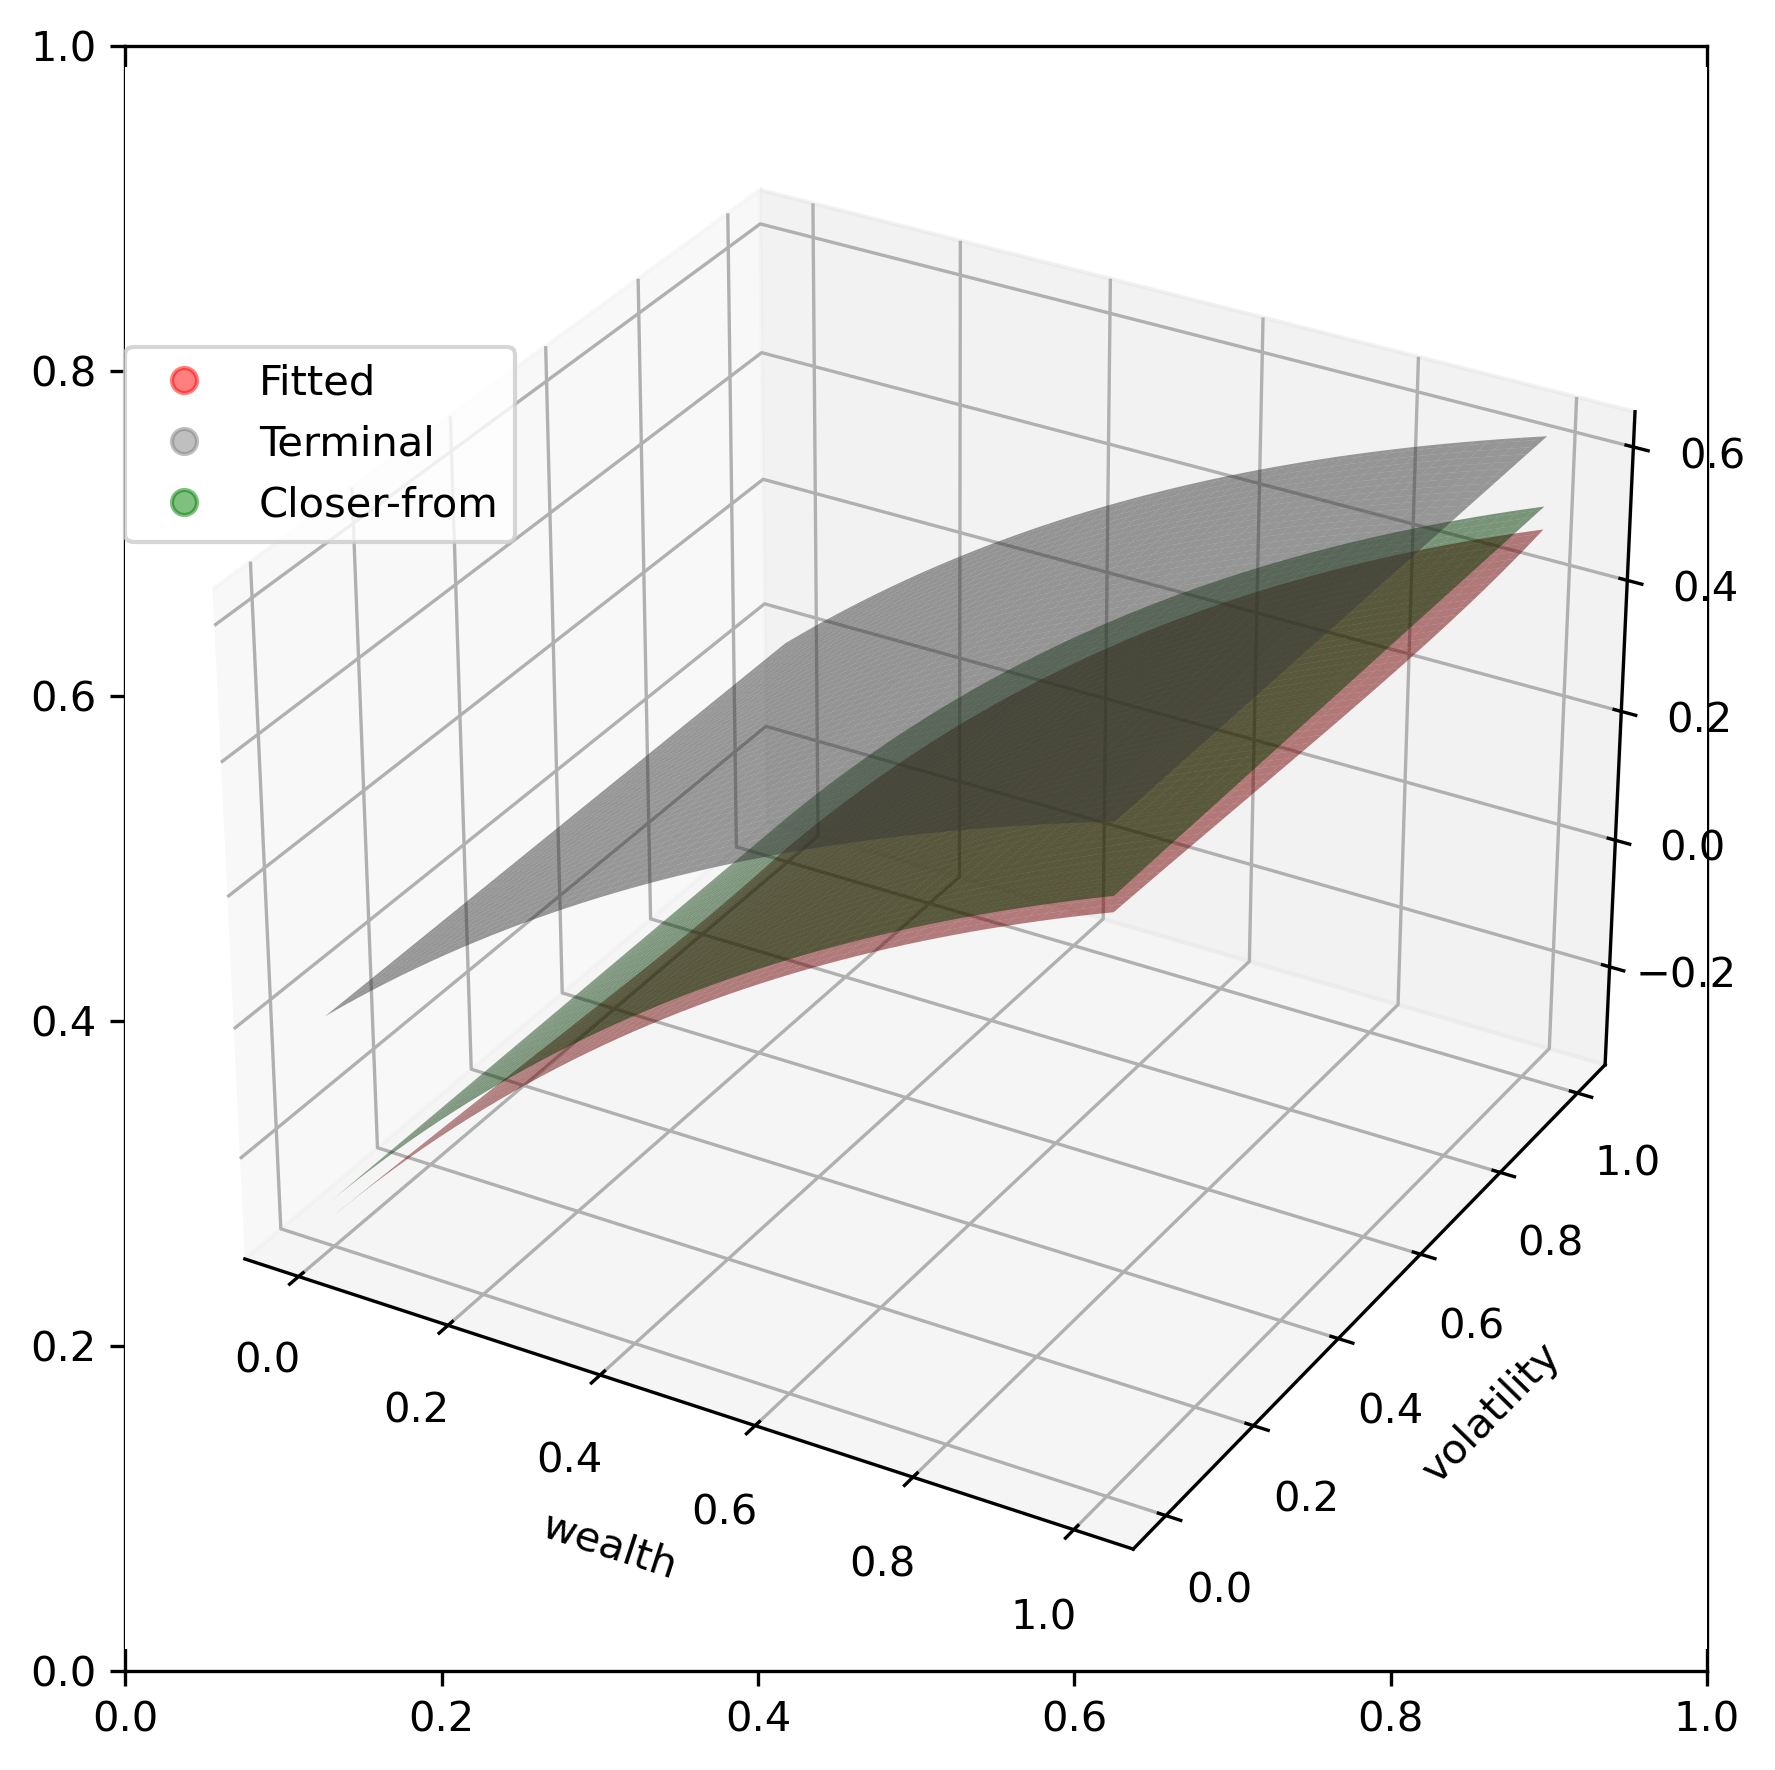

In [49]:
alpha = 0.5*torch.pow(off_diff*pde_params['eta'],2)
sol_lin = exp_solution(pde_params, alpha)
display_it(heat,closed_form=sol_lin,t=0.5);

## Linear with Z

In [50]:
class linearZ(object):
    def __init__(self,sigma,mu,source,kappa,terminal,pde,sim):        
        self.Y0 = Ynet() # NN for value at t=0 
        self.Z = Znet() # NN for gradient at all times
        self.Yt = Ytnet() # NN for value function at all times, required to update sigma
        self.terminal = terminal # terminal condition
        self.loss_epoch = [] # list to keep the loss at each training epoch
        self.epoch=0 # initializing epoch to zero
        # self.num_epochs = 5000 # total number of epochs
        self.mu = mu # drift of the SDE
        self.sigma = sigma # diffusion coef. for SDE
        self.kappa = kappa # discount factor
        self.source = source # source term for the PDE
        self.n = sim['num_time_intervals'] # number of time intervals
        # self.num_samples = sim['num_samples'] # number of samples 
        data = data_gen(sigma,mu,pde,sim)
        self.dt = data.dt.to(device)
        self.x = data.x.to(device).clone().detach()
        self.sigmadw = data.sigmadw.to(device).clone().detach()
        self.r = torch.ones((self.x.shape[0],1,self.n+1)).to(device)
        self.c = torch.ones((self.x.shape[0],1,self.n+1)).to(device)
        for i in range(self.n):
            self.r[:,:,i+1] = self.r[:,:,i]* torch.exp(-self.kappa(self.x[:,:,i])*self.dt)
            if i == self.n -1 :
                self.c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
            self.c[:,:,i] = self.source(self.x[:,:,i])
        self.r = self.r.clone().detach()
        self.c = self.c.clone().detach()
        self.trained = False
        
    def loss(self):
        # self.Zsigmadw = torch.zeros((num_samples,1,n)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                # self.Zsigmadw[:,:,i] = torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                Y = Y*self.r[:,:,i] + self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
        return torch.pow(self.c[:,:,-1]-Y,2).mean()
        
    def train(self,lr,delta_loss,max_num_epochs):
        t_0 = time.time()
        self.lr = lr
        parameters = list(self.Y0.parameters()) + list(self.Z.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = torch.Tensor([-2.0])
        loss = torch.Tensor([2.0])
        while (torch.abs(L_-loss)>delta_loss) & (self.epoch < max_num_epochs):# epoch in range(num_epochs):
            t_1 = time.time()
            optimizer.zero_grad()
            if self.epoch>0:
                L_ = self.loss_epoch[self.epoch-1]
            loss= self.loss()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
            loss.backward()
            optimizer.step()
            self.loss_epoch.append(loss)
            if (self.epoch % int(max_num_epochs/10)== int(max_num_epochs/10)-1) | (self.epoch == 0):
                print("At epoch {}, mean loss is {:.2E}.".format(self.epoch+1,loss.detach()))
                self.time_display(t_0, t_1)
            self.epoch += 1
        print("Training took {} epochs and {:,} ms and the final loss is {:.2E}.".format(self.epoch,round(1000*(time.time()-t_0),2),loss))
        self.trained = True
        self.value_fnc(lr=1e-2,delta_loss=delta_loss,max_num_epochs=1000,num_batches=10)

    def time_display(self, t_0, t_1):
        print("Training this epoch takes {:,} ms. So far: {:,} ms in training.".format(round(1000*(time.time()-t_1),2),round(1000*(time.time()-t_0),2)))
        
        
    def value_fnc(self,lr,delta_loss,max_num_epochs,num_batches):
        t_0 = time.time()
        if self.trained == False:
            print("The neural nets are not trained yet. Train the neural nets by running self.train(lr,delta_loss,max_num_epochs).")
        else:
            for i in range(self.n):   
                if i == 0:
                    Y =  self.Y0(self.x[:,1:,0])
                    x_data = self.x[:,:,i]
                    y_data = Y
                else:
                    if i == self.n - 1:
                        Y = self.terminal(self.x[:,1:,i+1])
                        x_data = torch.cat((x_data,self.x[:,:,i+1]),axis=0)
                        y_data = torch.cat((y_data,Y),axis=0)
                        #evaluate and reuse self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))[:,0,0] 
                    Y = Y*self.r[:,:,i] + self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)        
                    x_data = torch.cat((x_data,self.x[:,:,i]),axis=0)
                    y_data = torch.cat((y_data,Y),axis=0)
            print("Data for value function is gathered in {:,} ms.".format(round(1000*(time.time()-t_0),2)))
            perm = torch.randperm(x_data.shape[0])
            y_data = y_data[perm,:].clone().detach()
            x_data = x_data[perm,:].clone().detach()
            parameters = self.Yt.parameters()
            optimizer = optim.Adam(parameters, lr)
            L_ = torch.Tensor([-2.0])
            loss = torch.Tensor([2.0])
            initiation = True # to print the first epoch or last epoch in multiple rounds of training
            epoch=0
            mse = nn.MSELoss()
            batch_size = int(x_data.shape[0]/num_batches)
            batch_epochs = int(max_num_epochs/num_batches)
            b=0
            # loss_epoch = []
            # max_num_epochs = 500
            t_0 = time.time()
            while (torch.abs(L_-loss)>delta_loss) & (epoch < max_num_epochs):# epoch in range(num_epochs):
                optimizer.zero_grad()
                if epoch>0:
                    L_ = loss
                index = [b*batch_size, x_data.shape[0]] if (b+1==num_batches) else [b*batch_size, (b+1)*batch_size]    
                loss= mse(self.Yt(x_data[index[0]:index[1],:]),y_data[index[0]:index[1],:])
                loss.backward()
                optimizer.step()
                if epoch == (b+1)*batch_epochs:
                    print("At epoch {:,} batch {} is used.".format(epoch+1,b+2))
                if epoch >= (b+1)*batch_epochs:
                    b = b + 1
                
                if initiation:
                    initiation = False
                    print("\nFitting a neural net to the data initiated.")
                    print("The L^2 error of the fitted value function at epoch {} is {:.2E}.".format(epoch+1,torch.sqrt(loss.detach())))
                if (epoch % int(max_num_epochs/5)== int(max_num_epochs/5)-1):    
                    print("The $L^2$-norm of the error of the fitted value function at epoch {} is {:.2E}.".format(epoch+1,torch.sqrt(loss.detach())))
                epoch += 1
            print("Value function is evaluated in {:,} ms.".format(round(1000*(time.time()-t_0),2)))

In [51]:
mu = OU_drift_semi(pde_params)
off_diff = torch.tensor([1.0]) #choose larger diffusion coef to make the difference between the terminal and time-zero solution larger
sigma = constant_diff(pde_params,constant_diff = off_diff)# With large constant_diff the trainning sucks!
k = zero_discount(pde_params)
f = zero_source(pde_params)
g = exponential_terminal(pde_params)

In [52]:
heatZ = linearZ(sigma,mu,f,k,g,pde_params,sim_params)

In [53]:
heatZ.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1, mean loss is 2.37E+00.
Training this epoch takes 17.05 ms. So far: 19.79 ms in training.
At epoch 500, mean loss is 1.22E-01.
Training this epoch takes 18.54 ms. So far: 7,926.47 ms in training.
At epoch 1000, mean loss is 1.09E-01.
Training this epoch takes 15.92 ms. So far: 16,014.91 ms in training.
At epoch 1500, mean loss is 1.04E-01.
Training this epoch takes 21.09 ms. So far: 24,260.76 ms in training.
At epoch 2000, mean loss is 1.02E-01.
Training this epoch takes 15.97 ms. So far: 32,523.15 ms in training.
At epoch 2500, mean loss is 9.85E-02.
Training this epoch takes 16.98 ms. So far: 40,863.69 ms in training.
At epoch 3000, mean loss is 9.42E-02.
Training this epoch takes 16.18 ms. So far: 49,150.82 ms in training.
At epoch 3500, mean loss is 9.15E-02.
Training this epoch takes 16.39 ms. So far: 57,530.75 ms in training.
At epoch 4000, mean loss is 8.89E-02.
Training this epoch takes 18.57 ms. So far: 66,737.1 ms in training.
At epoch 4500, mean loss is 8.72E-02.


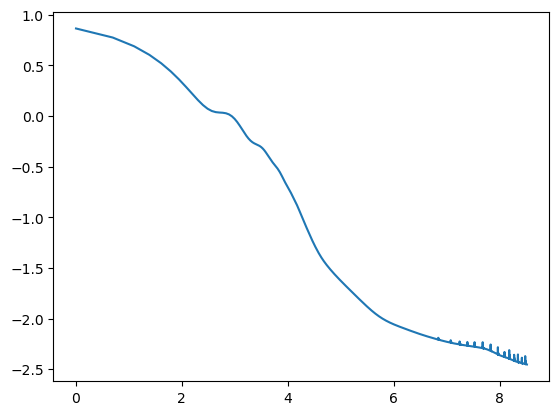

In [54]:
plt.plot(np.log(np.arange(len(heatZ.loss_epoch))+1),[np.log(l.detach().numpy()) for l in heatZ.loss_epoch]);

The $L^2$ distance between the fitted value function and closed-form for optimal $\sigma$ is  8.996E-03.

The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  1.670E-03.

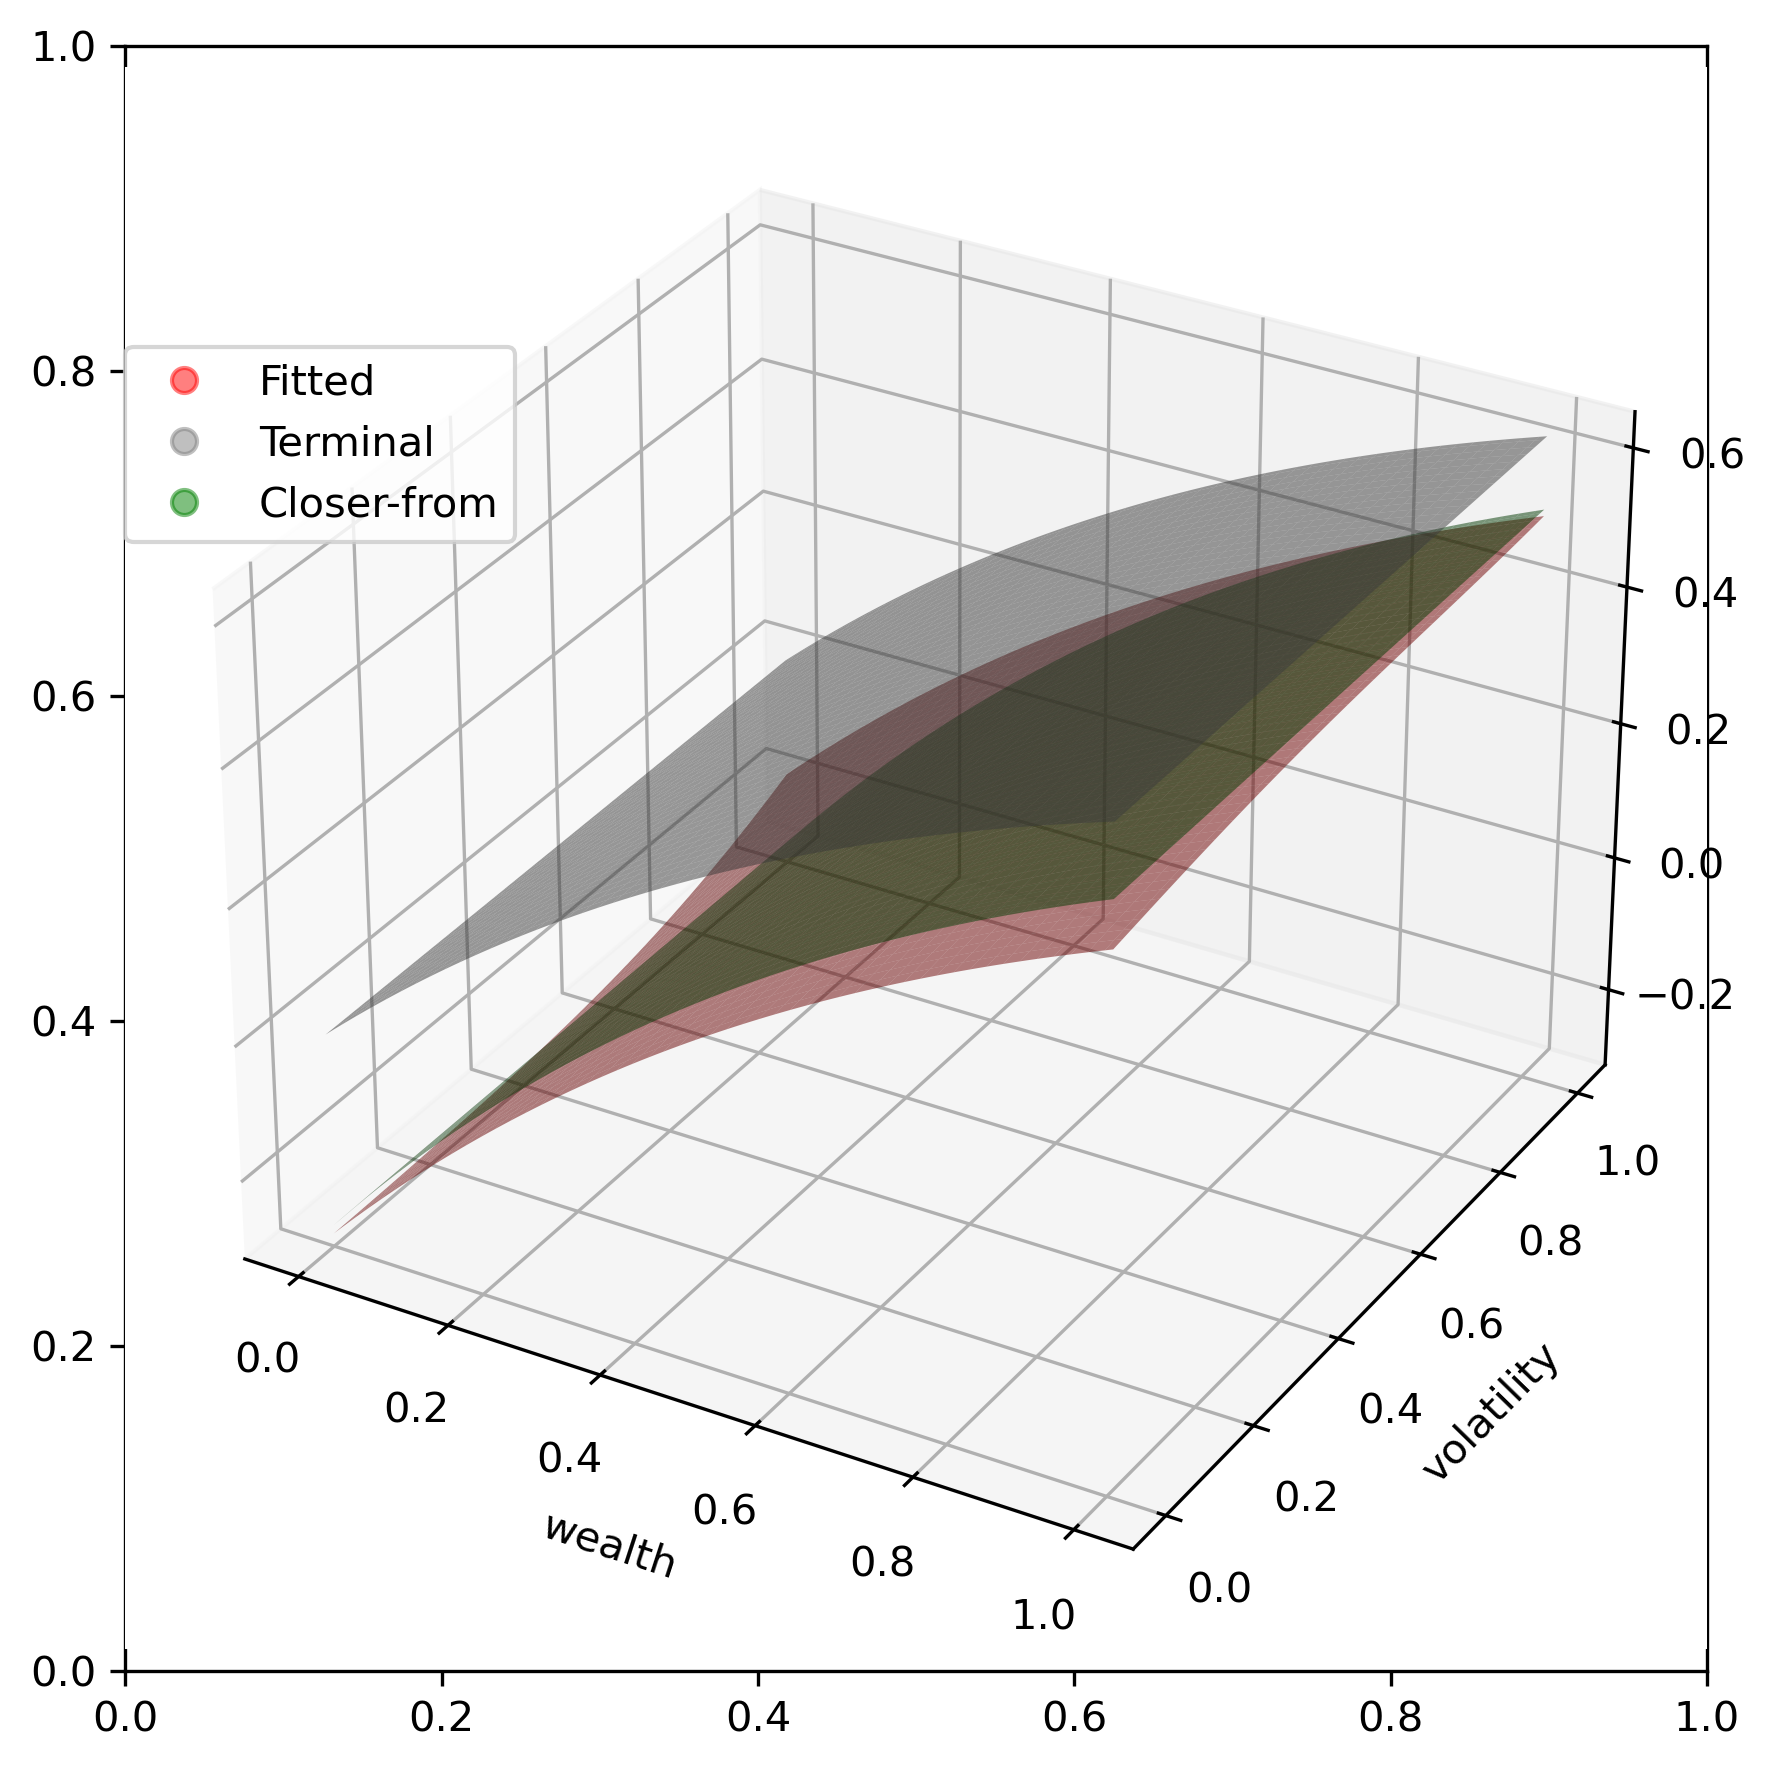

In [55]:
# alpha = 0.5*torch.pow(off_diff*pde_params['eta'],2)
# sol_lin = exp_solution(pde_params, alpha)
display_it(heatZ,closed_form=sol_lin,t=0.5);

In [56]:
heatZ.value_fnc(lr=1e-2,delta_loss=1e-9,max_num_epochs=1000,num_batches=5)
# print(heatZ.x_data.shape,heatZ.y_data.shape)

Data for value function is gathered in 31.97 ms.

Fitting a neural net to the data initiated.
The L^2 error of the fitted value function at epoch 1 is 3.93E-01.
The $L^2$-norm of the error of the fitted value function at epoch 200 is 3.86E-01.
At epoch 201 batch 2 is used.
The $L^2$-norm of the error of the fitted value function at epoch 400 is 3.97E-01.
At epoch 401 batch 3 is used.
The $L^2$-norm of the error of the fitted value function at epoch 600 is 4.02E-01.
At epoch 601 batch 4 is used.
The $L^2$-norm of the error of the fitted value function at epoch 800 is 3.67E-01.
At epoch 801 batch 5 is used.
The $L^2$-norm of the error of the fitted value function at epoch 1000 is 3.76E-01.
Value function is evaluated in 138,796.29 ms.


The $L^2$ distance between the fitted value function and closed-form for optimal $\sigma$ is  9.996E-03.

The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  1.609E-03.

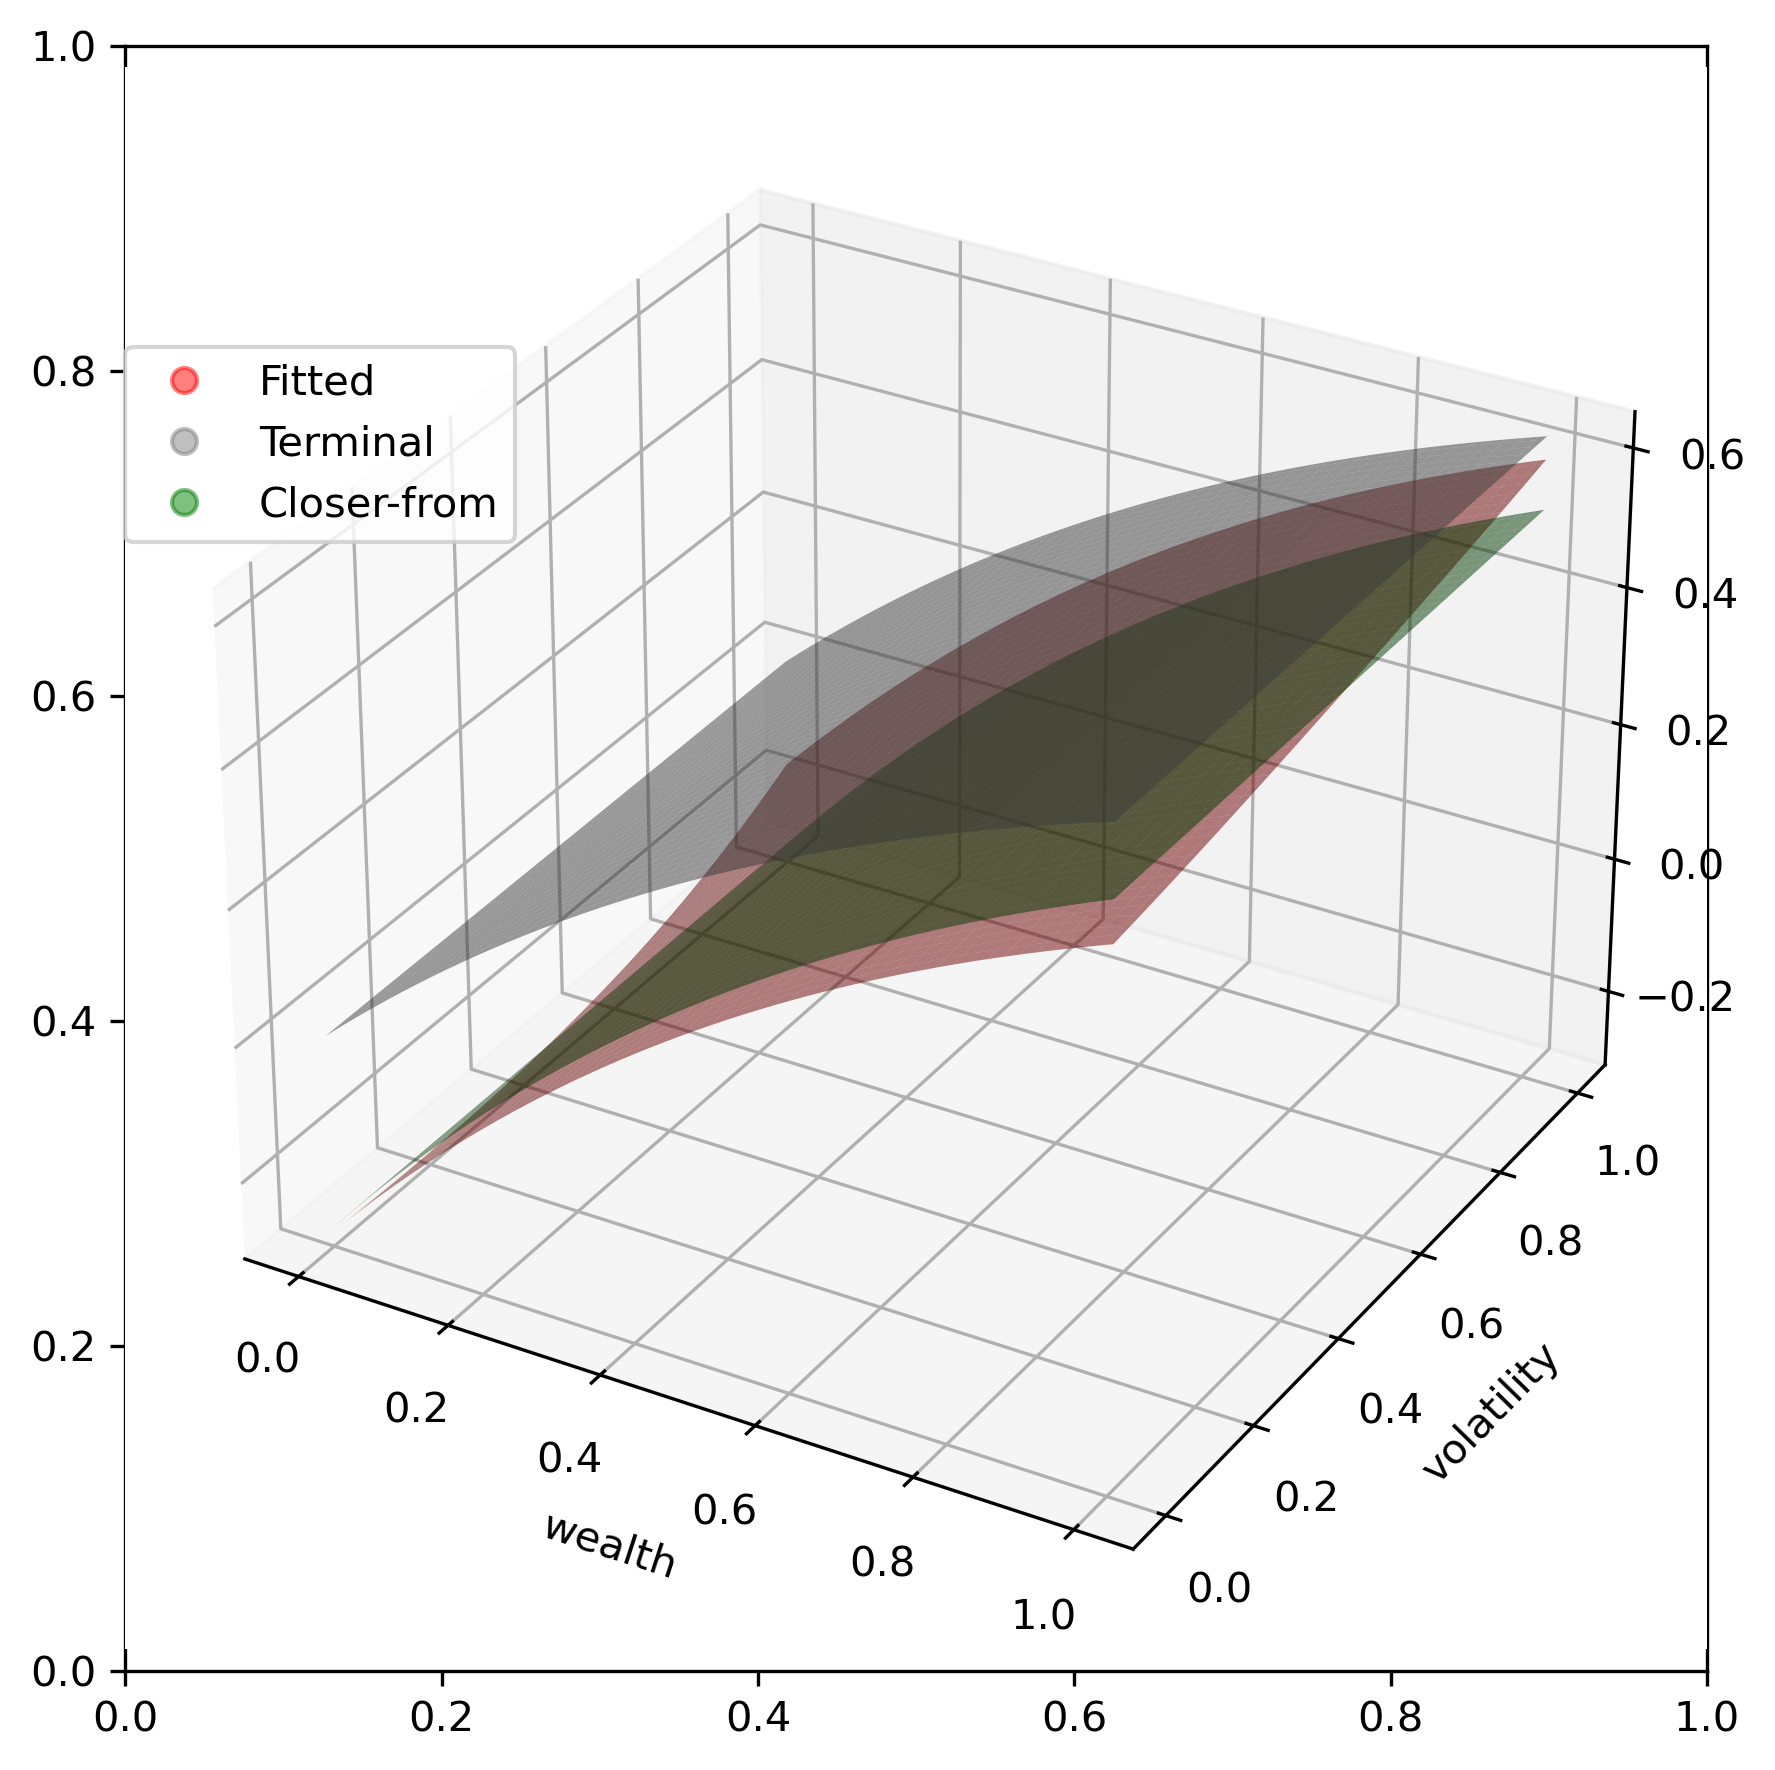

In [57]:
display_it(heatZ,closed_form=sol_lin,t=0.5);